In [11]:
import pandas as pd
import numpy as np
import gcnIO
import os
from functools import reduce

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import average_precision_score, precision_recall_curve
from scipy import interp

import matplotlib.pyplot as plt
import seaborn
plt.rc('font', family='Times New Roman')
import matplotlib_venn
%matplotlib inline

In [12]:
model_dir = '../data/GCN/training/2018_09_02_16_40_40/'

args, data_file = gcnIO.load_hyper_params(model_dir)
data = gcnIO.load_hdf_data(data_file)
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names = data
print ("Data comes from {}".format(data_file))
print (args)
CLASSIFICATION_THRESHOLD = 0.5


Hyper-Parameters read from ../data/GCN/training/2018_09_02_16_40_40/hyper_params.txt
Data comes from ../data/pancancer/iref_multiomicsmethnew_norm_ncglabels.h5
{'data': '../data/pancancer/iref_multiomicsmethnew_norm_ncglabels.h5', 'decay': 0.0005, 'cv_runs': 10, 'lr': 0.001, 'support': 2, 'epochs': 7000, 'hidden_dims': [50, 40, 30, 20, 10], 'dropout': 0.5, 'loss_mul': 30.0}


## Read Predictions

In [13]:
pred_all = []
sets_all = []
no_cv = 0
for cv_dir in os.listdir(model_dir):
    if cv_dir.startswith('cv_'):
        predictions = pd.DataFrame.from_csv(os.path.join(model_dir, cv_dir, 'predictions.tsv'), sep='\t', header=0)
        pred_all.append(predictions)
        y_train, y_test, train_mask, test_mask = gcnIO.read_train_test_sets(os.path.join(model_dir, cv_dir))
        sets_all.append((y_train, y_test, train_mask, test_mask))
        no_cv += 1
print ("Read predictions from {} CV runs".format(no_cv))

Read predictions from 10 CV runs


## Get ensemble predictions

In [14]:
# get node names
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
nodes.set_index('ID')
nodes['label'] = np.logical_or(y_train, y_test)
# construct ensemble data frame
ensemble_predictions = reduce(lambda left,right: pd.merge(left,right,on='Name'), pred_all)
# get the names corrected
ensemble_predictions.columns = ['Name'] + ['Prob_pos_{}'.format(i) for i in range(1, no_cv+1)]
# restore the IDs which were lost during merging (together with the correct order)
ensemble_predictions = nodes.join(ensemble_predictions, lsuffix='2')
ensemble_predictions.drop('Name2', axis=1, inplace=True)
ensemble_predictions.set_index('ID', inplace=True)
# add columns for mean statistics (number predictions, mean prediction, std)
number_cols = [i for i in ensemble_predictions.columns if i.startswith('Prob_pos_')]
ensemble_predictions['Num_Pos'] = (ensemble_predictions[number_cols] > 0.5).sum(axis=1)
ensemble_predictions['Mean_Pred'] = ensemble_predictions[number_cols].mean(axis=1)
ensemble_predictions['Std_Pred'] = ensemble_predictions[number_cols].std(axis=1)
# write to file
ens_pred_sorted = ensemble_predictions.sort_values(by='Mean_Pred', ascending=False)
ens_pred_sorted.to_csv(os.path.join(model_dir, 'ensemble_predictions.tsv'), sep='\t')
ens_pred_sorted.head()

,label,Name,Prob_pos_1,Prob_pos_2,Prob_pos_3,Prob_pos_4,Prob_pos_5,Prob_pos_6,Prob_pos_7,Prob_pos_8,Prob_pos_9,Prob_pos_10,Num_Pos,Mean_Pred,Std_Pred
ID,,,,,,,,,,,,,,,
ENSG00000197122,True,SRC,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10,1.0,0.0
ENSG00000100393,True,EP300,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10,1.0,0.0
ENSG00000116478,False,HDAC1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10,1.0,0.0
ENSG00000141510,True,TP53,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10,1.0,0.0
ENSG00000005339,True,CREBBP,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10,1.0,0.0


# Average ROC Curve

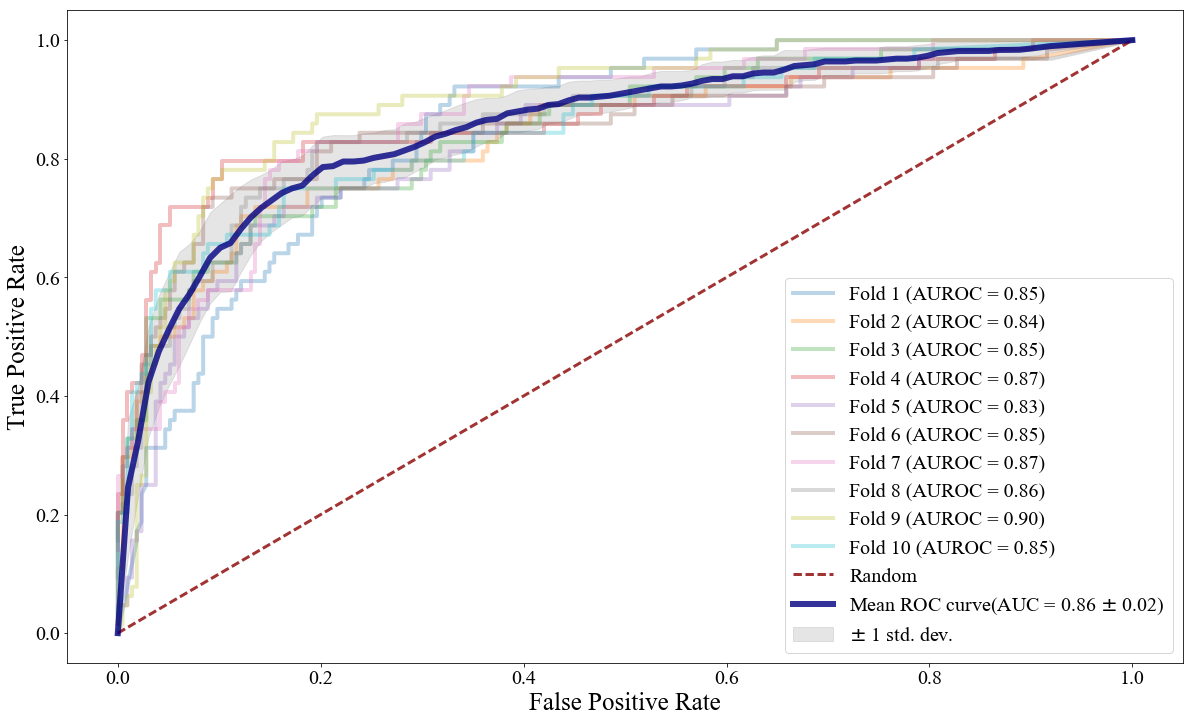

In [15]:
# construct test set statistics
fig = plt.figure(figsize=(20, 12))

k = 1
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for pred in pred_all:
    y_t = sets_all[k-1][1]
    m_t = sets_all[k-1][3]
    fpr, tpr, _ = roc_curve(y_score=pred[m_t].Prob_pos, y_true=y_t[m_t])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    auroc = roc_auc_score(y_score=pred[m_t].Prob_pos, y_true=y_t[m_t])
    aucs.append(auroc)
    plt.plot(fpr, tpr, lw=4, alpha=0.3, label='Fold %d (AUROC = %0.2f)' % (k, auroc))
    k += 1

# plot random line
plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='darkred',
         label='Random', alpha=.8)

# plot mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='navy',
         label=r'Mean ROC curve(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=6, alpha=.8)

# plot std dev
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=25)
plt.ylabel('True Positive Rate', fontsize=25)
#plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right", prop={'size': 20})
plt.tick_params(axis='both', labelsize=20)
fig.savefig(os.path.join(model_dir, 'mean_ROC_curve.svg'))
fig.savefig(os.path.join(model_dir, 'mean_ROC_curve.png'), dpi=300)

## Average PR Curve

1.0 1.0 0.0


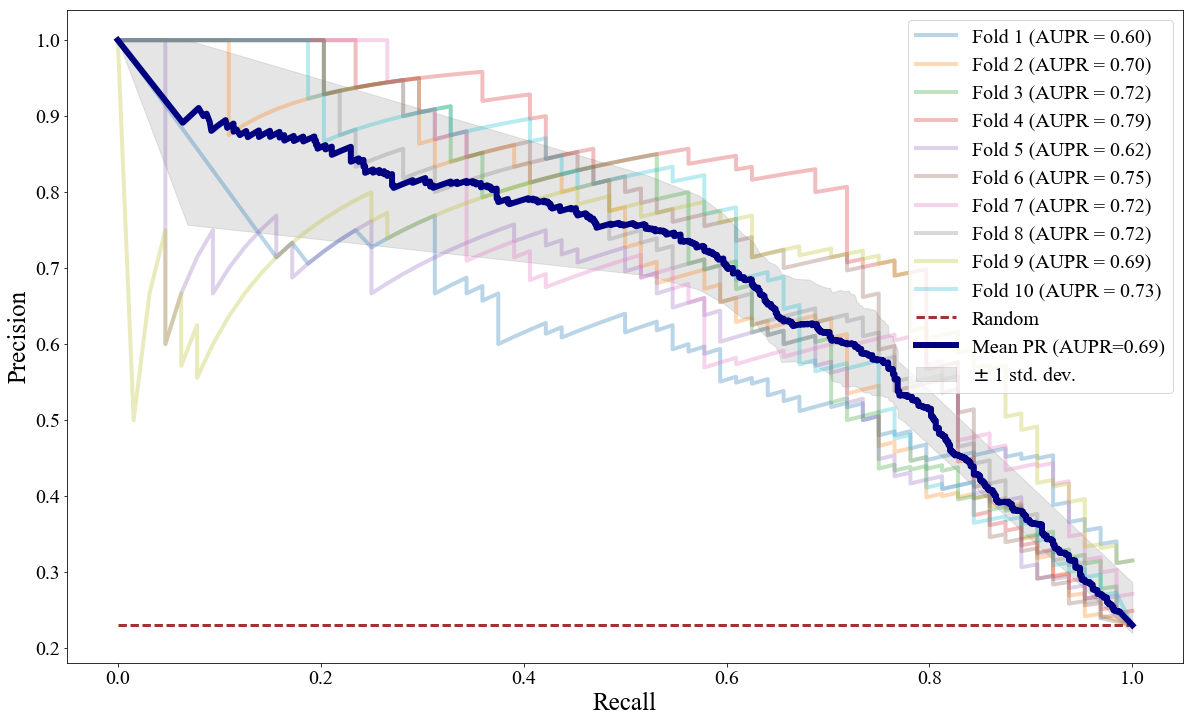

In [16]:
fig = plt.figure(figsize=(20, 12))

k = 1
y_true = []
y_pred = []
pr_values = []
rec_values = []
sample_thresholds = np.linspace(0, 1, 100)
no_pos = []
no_total = []
for pred in pred_all:
    y_t = sets_all[k-1][1] # test labels
    m_t = sets_all[k-1][3] # test mask
    pr, rec, thr = precision_recall_curve(probas_pred=pred[m_t].Prob_pos, y_true=y_t[m_t])
    no_pos.append(y_t.sum())
    no_total.append(m_t.sum())
    pr_values.append(interp(sample_thresholds, thr, pr[:-1]))
    #pr_values[-1][-1] = 1.0
    rec_values.append(interp(sample_thresholds, thr, rec[:-1]))
    aupr = average_precision_score(y_score=pred[m_t].Prob_pos, y_true=y_t[m_t])
    plt.plot(rec, pr, lw=4, alpha=0.3, label='Fold %d (AUPR = %0.2f)' % (k, aupr))
    y_true.append(y_t[m_t])
    y_pred.append(pred[m_t].Prob_pos)
    k += 1

# plot random line
rand_perf = np.mean(no_pos) / np.mean(no_total)
plt.plot([0, 1], [rand_perf, rand_perf], linestyle='--', lw=3, color='darkred',
         label='Random', alpha=.8)

# plot mean curve (PR curve over all folds)
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
mean_precision, mean_recall, _ = precision_recall_curve(y_true, y_pred)
label = 'Mean PR (AUPR=%.2f)' % (auc(mean_recall, mean_precision))
plt.plot(mean_recall, mean_precision, label=label, lw=6, color='navy')

# plot std dev
std_pr = np.std(pr_values, axis=0)
mean_pr = np.mean(pr_values, axis=0)
mean_rec = np.mean(rec_values, axis=0)
pr_upper = np.minimum(mean_pr + std_pr, 1)
pr_lower = np.maximum(mean_pr - std_pr, 0)
pr_upper = np.append(pr_upper, 1.)
pr_lower = np.append(pr_lower, 1.)
mean_rec = np.append(mean_rec, 0.)
print (pr_upper[-1], pr_lower[-1], mean_rec[-1])

plt.fill_between(mean_rec, pr_lower, pr_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.tick_params(axis='both', labelsize=20)
plt.xlabel('Recall', fontsize=25)
plt.ylabel('Precision', fontsize=25)
plt.legend(loc='upper right', prop={'size':20})
fig.savefig(os.path.join(model_dir, 'mean_PR_curve.svg'))
fig.savefig(os.path.join(model_dir, 'mean_PR_curve.png'), dpi=300)

## Overlap with NCG Cancer Genes

In [17]:
known_cancer_genes = []
candidate_cancer_genes = []
n = 0
with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
    for line in f.readlines():
        n += 1
        if n == 1:
            continue
        l = line.strip().split('\t')
        if len(l) == 2:
            known_cancer_genes.append(l[0])
            candidate_cancer_genes.append(l[1])
        else:
            candidate_cancer_genes.append(l[0])

known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
candidate_cancer_genes_innet = nodes[nodes.Name.isin(candidate_cancer_genes)].Name

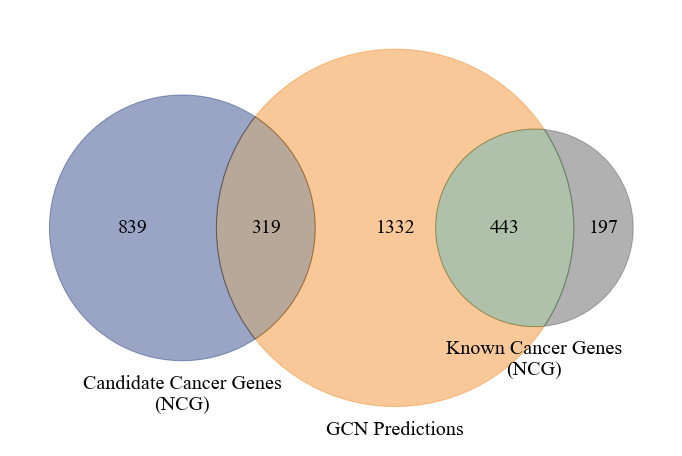

In [20]:
fig = plt.figure(figsize=(14, 8))
v = matplotlib_venn.venn3([set(known_cancer_genes_innet),
                           set(ensemble_predictions[ensemble_predictions.Num_Pos == no_cv].Name),
                           set(candidate_cancer_genes_innet)],
          set_labels=['Known Cancer Genes\n(NCG)', 'GCN Predictions', 'Candidate Cancer Genes\n(NCG)'])
v.get_patch_by_id('10').set_color('#3d3e3d')
v.get_patch_by_id('11').set_color('#37652d')
v.get_patch_by_id('01').set_color('#ee7600')
#v.get_patch_by_id('111').set_color('#890707')
#v.get_patch_by_id('101').set_color('#6E80B7')
v.get_patch_by_id('011').set_color('#4d2600')
v.get_patch_by_id('001').set_color('#031F6F')
v.get_label_by_id('A').set_fontsize(20)
v.get_label_by_id('B').set_fontsize(20)
v.get_label_by_id('C').set_fontsize(20)
v.get_label_by_id('10').set_fontsize(20)
v.get_label_by_id('11').set_fontsize(20)
v.get_label_by_id('01').set_fontsize(20)
#v.get_label_by_id('111').set_fontsize(20)
#v.get_label_by_id('101').set_fontsize(20)
v.get_label_by_id('011').set_fontsize(20)
v.get_label_by_id('001').set_fontsize(20)
fig.savefig(os.path.join(model_dir, 'overlap_NCG_genes.svg'))
fig.savefig(os.path.join(model_dir, 'overlap_NCG_genes.png'), dpi=300)

## List of Potential Candidates from GCN

In [21]:
all_ncg_genes = known_cancer_genes + candidate_cancer_genes
ensemble_predictions[~ensemble_predictions.Name.isin(all_ncg_genes)].sort_values(by='Mean_Pred', ascending=False).head(20)

,label,Name,Prob_pos_1,Prob_pos_2,Prob_pos_3,Prob_pos_4,Prob_pos_5,Prob_pos_6,Prob_pos_7,Prob_pos_8,Prob_pos_9,Prob_pos_10,Num_Pos,Mean_Pred,Std_Pred
ID,,,,,,,,,,,,,,,
ENSG00000116478,False,HDAC1,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.000000,10,1.000000,0.000000e+00
ENSG00000171720,False,HDAC3,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.000000,10,1.000000,3.769729e-08
ENSG00000185591,False,SP1,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.000000,10,1.000000,3.769729e-08
ENSG00000114166,False,KAT2B,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.000000,10,1.000000,7.539457e-08
ENSG00000277775,False,HIST1H3F,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.000000,10,1.000000,1.513118e-07
ENSG00000143799,False,PARP1,1.0,1.0,0.999999,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.000000,10,1.000000,2.662637e-07
ENSG00000109320,False,NFKB1,1.0,1.0,0.999999,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.000000,10,1.000000,2.500555e-07
ENSG00000188612,False,SUMO2,1.0,1.0,0.999999,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.000000,10,1.000000,3.036654e-07
ENSG00000158092,False,NCK1,1.0,1.0,0.999999,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.000000,10,1.000000,4.060122e-07


In [20]:
len(known_cancer_genes)

711